# Logistic Regression

Think Bayes, Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for empiricaldist: filename=empiricaldist-0.7.2-py3-none-any.whl size=12205 sha256=a493f9e7ceda3168cc0c7067ea6175dc225229806fec55e98bb048ab45d18838
  Stored in directory: /root/.cache/pip/wheels/e9/57/8a/15b864f4d5dc20cef626e3a015fec88b19df385ef30a8364cc
Successfully built empiricaldist


In [2]:
# Get utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

Downloaded utils.py


In [3]:
from utils import set_pyplot_params
set_pyplot_params()

This chapter introduces two related topics: log odds and logistic regression.

In <<_BayessRule>>, we rewrote Bayes's Theorem in terms of odds and derived Bayes's Rule, which can be a convenient way to do a Bayesian update on paper or in your head.
In this chapter, we'll look at Bayes's Rule on a logarithmic scale, which provides insight into how we accumulate evidence through successive updates.

That leads directly to logistic regression, which is based on a linear model of the relationship between evidence and the log odds of a hypothesis.
As an example, we'll use data from the Space Shuttle to explore the relationship between temperature and the probability of damage to the O-rings.

As an exercise, you'll have a chance to model the relationship between a child's age when they start school and their probability of being diagnosed with Attention Deficit Hyperactivity Disorder (ADHD).

## Log Odds

When I was in grad school, I signed up for a class on the Theory of Computation.
On the first day of class, I was the first to arrive.
A few minutes later, another student arrived.

At the time, about 83% of the students in the computer science program [were male](https://www.aps.org/programs/education/statistics/fraction-phd.cfm), so I was mildly surprised to note that the other student was female.

When another female student arrived a few minutes later, I started to think I was in the wrong room.
When third female student arrived, I was confident I was in the wrong room.
And as it turned out, I was.

I'll use this anecdote to demonstrate Bayes's Rule on a logarithmic scale and show how it relates to logistic regression.

Using $H$ to represent the hypothesis that I was in the right room, and $F$ to represent the observation that the first other student was female, we can write Bayes's Rule like this:

$$O(H|F) = O(H) \frac{P(F|H)}{P(F|not H)}$$

Before I saw the other students, I was confident I was in the right room, so I might assign prior odds of 10:1 in favor:

$$O(H) = 10$$


If I was in the right room, the likelihood of the first female student was about 17%.
If I was not in the right room, the likelihood of the first female student was more like 50%,

$$\frac{P(F|H)}{P(F|not H)} = 17 / 50$$

So the likelihood ratio is close to 1/3.  Applying Bayes's Rule, the posterior odds were

$$O(H|F) = 10 / 3$$

After two students, the posterior odds were

$$O(H|FF) = 10 / 9$$

And after three students:

$$O(H|FFF) = 10 / 27$$

At that point, I was right to suspect I was in the wrong room.

The following table shows the odds after each update, the corresponding probabilities, and the change in probability after each step, expressed in percentage points.

In [4]:
def prob(o):
    return o / (o+1)

In [6]:
import pandas as pd

index = ['prior', '1 student', '2 students', '3 students']

table = pd.DataFrame(index=index)
table['odds'] = [10, 10/3, 10/9, 10/27]
table['prob'] = prob(table['odds'])
table['prob diff'] = table['prob'].diff() * 100
table.fillna('--')

,odds,prob,prob diff
prior,10.000000,0.909091,--
1 student,3.333333,0.769231,-13.986014
2 students,1.111111,0.526316,-24.291498
3 students,0.370370,0.270270,-25.604552


Each update uses the same likelihood, but the changes in probability are not the same.  The first update decreases the probability by about 14 percentage points, the second by 24, and the third by 26.
That's normal for this kind of update, and in fact it's necessary; if the changes were the same size, we would quickly get into negative probabilities.

The odds follow a more obvious pattern.  Because each update multiplies the odds by the same likelihood ratio, the odds form a geometric sequence.
And that brings us to consider another way to represent uncertainty: **log odds**, which is the logarithm of odds, usually expressed using the natural log (base $e$).

Adding log odds to the table:

In [7]:
import numpy as np

table['log odds'] = np.log(table['odds'])
table['log odds diff'] = table['log odds'].diff()
table.fillna('--')

,odds,prob,prob diff,log odds,log odds diff
prior,10.000000,0.909091,--,2.302585,--
1 student,3.333333,0.769231,-13.986014,1.203973,-1.098612
2 students,1.111111,0.526316,-24.291498,0.105361,-1.098612
3 students,0.370370,0.270270,-25.604552,-0.993252,-1.098612


You might notice:

* When probability is greater than 0.5, odds are greater than 1, and log odds are positive.

* When probability is less than 0.5, odds are less than 1, and log odds are negative.

You might also notice that the log odds are equally spaced.
The change in log odds after each update is the logarithm of the likelihood ratio.

In [8]:
np.log(1/3)

-1.0986122886681098

That's true in this example, and we can show that it's true in general by taking the log of both sides of Bayes's Rule.

$$\log O(H|F) = \log O(H) + \log \frac{P(F|H)}{P(F|not H)}$$

On a log odds scale, a Bayesian update is additive.  So if $F^x$ means that $x$ female students arrive while I am waiting, the posterior log odds that I am in the right room are:

$$\log O(H|F^x) = \log O(H) + x \log \frac{P(F|H)}{P(F|not H)}$$

This equation represents a linear relationship between the log likelihood ratio and the posterior log odds.  

In this example the linear equation is exact, but even when it's not, it is common to use a linear function to model the relationship between an explanatory variable, $x$, and a dependent variable expressed in log odds, like this:

$$\log O(H | x) = \beta_0 + \beta_1 x$$

where $\beta_0$ and $\beta_1$ are unknown parameters:

* The intercept, $\beta_0$, is the log odds of the hypothesis when $x$ is 0.

* The slope, $\beta_1$, is the log of the likelihood ratio.

This equation is the basis of logistic regression.

## The Space Shuttle Problem

As an example of logistic regression, I'll solve a problem from Cameron Davidson-Pilon's book, [*Bayesian Methods for Hackers*](http://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter2_MorePyMC/Ch2_MorePyMC_PyMC2.ipynb).  He writes:

> "On January 28, 1986, the twenty-fifth flight of the U.S. space shuttle program ended in disaster when one of the rocket boosters of the Shuttle Challenger exploded shortly after lift-off, killing all seven crew members. The presidential commission on the accident concluded that it was caused by the failure of an O-ring in a field joint on the rocket booster, and that this failure was due to a faulty design that made the O-ring unacceptably sensitive to a number of factors including outside temperature. Of the previous 24 flights, data were available on failures of O-rings on 23 (one was lost at sea), and these data were discussed on the evening preceding the Challenger launch, but unfortunately only the data corresponding to the 7 flights on which there was a damage incident were considered important and these were thought to show no obvious trend."

The dataset is originally from [this paper](https://amstat.tandfonline.com/doi/abs/10.1080/01621459.1989.10478858), but also available from [Davidson-Pilon](https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter2_MorePyMC/data/challenger_data.csv).

In [9]:
download('https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter2_MorePyMC/data/challenger_data.csv')

Downloaded challenger_data.csv


I'll read the data and do some cleaning.

In [10]:
data = pd.read_csv('challenger_data.csv', parse_dates=[0])

# avoiding column names with spaces
data.rename(columns={'Damage Incident': 'Damage'}, inplace=True)

# dropping row 3, in which Damage Incident is NaN,
# and row 24, which is the record for the Challenger
data.drop(labels=[3, 24], inplace=True)

# convert the Damage column to integer
data['Damage'] = data['Damage'].astype(int)

data

,Date,Temperature,Damage
0,04/12/1981,66,0
1,11/12/1981,70,1
2,3/22/82,69,0
4,01/11/1982,68,0
5,04/04/1983,67,0
6,6/18/83,72,0
7,8/30/83,73,0
8,11/28/83,70,0
9,02/03/1984,57,1
10,04/06/1984,63,1


Here are the first few rows:

In [11]:
data.head()

,Date,Temperature,Damage
0,04/12/1981,66,0
1,11/12/1981,70,1
2,3/22/82,69,0
4,01/11/1982,68,0
5,04/04/1983,67,0


The columns are:

* `Date`: The date of launch,

* `Temperature`: Outside temperature in Fahrenheit, and

* `Damage`: `1` if there was a damage incident and `0` otherwise.

There are 23 launches in the dataset, 7 with damage incidents.

In [12]:
len(data), data['Damage'].sum()

(23, 7)

The following figure shows the relationship between damage and temperature.

In [13]:
import matplotlib.pyplot as plt
from utils import decorate

def plot_data(data):
    """Plot damage as a function of temperature.

    data: DataFrame
    """
    plt.plot(data['Temperature'], data['Damage'], 'o',
             label='data', color='C0', alpha=0.4)

    decorate(ylabel="Probability of damage",
         xlabel="Outside temperature (deg F)",
         title="Damage to O-Rings vs Temperature")

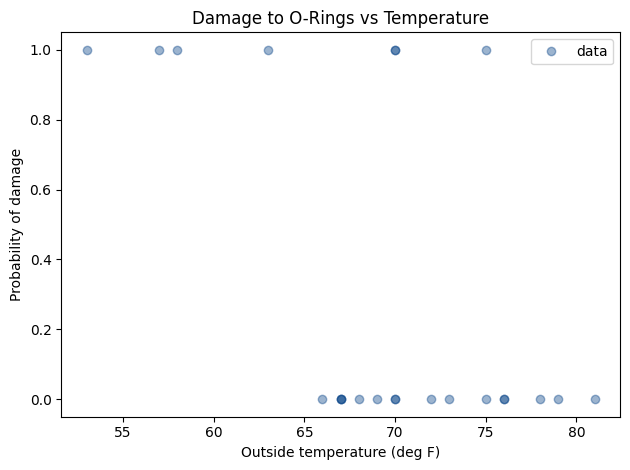

In [14]:
plot_data(data)

When the outside temperature was below 65 degrees, there was always damage to the O-rings.  When the temperature was above 65 degrees, there was usually no damage.  

Based on this figure, it seems plausible that the probability of damage is related to temperature.  If we assume this probability follows a logistic model, we can write:

$$\log O(H | x) = \beta_0 + \beta_1 x$$

where $H$ is the hypothesis that the O-rings will be damaged, $x$ is temperature, and $\beta_0$ and $\beta_1$ are the parameters we will estimate.
For reasons I'll explain soon, I'll define $x$ to be temperature shifted by an offset so its mean is 0.

In [16]:
offset = data['Temperature'].mean().round()
data['x'] = data['Temperature'] - offset
offset

70.0

And for consistency I'll create a copy of the `Damage` columns called `y`.

In [17]:
data['y'] = data['Damage']

Before doing a Bayesian update, I'll use `statsmodels` to run a conventional (non-Bayesian) logistic regression.

In [18]:
import statsmodels.formula.api as smf

formula = 'y ~ x'
results = smf.logit(formula, data=data).fit(disp=False)
results.params

Intercept   -1.208490
x           -0.232163
dtype: float64

`results` contains a "point estimate" for each parameter, that is, a single value rather than a posterior distribution.

The intercept is about -1.2, and the estimated slope is about -0.23.
To see what these parameters mean, I'll use them to compute probabilities for a range of temperatures.
Here's the range:

In [20]:
inter = results.params['Intercept']
slope = results.params['x']
xs = np.arange(53, 83) - offset

We can use the logistic regression equation to compute log odds:

In [21]:
log_odds = inter + slope * xs

And then convert to probabilities.

In [22]:
odds = np.exp(log_odds)
ps = odds / (odds + 1)

In [23]:
ps.mean()

0.4155141126966854

Converting log odds to probabilities is a common enough operation that it has a name, `expit`, and SciPy provides a function that computes it.

In [24]:
from scipy.special import expit

ps = expit(inter + slope * xs)

In [25]:
ps.mean()

0.4155141126966854

Here's what the logistic model looks like with these estimated parameters.

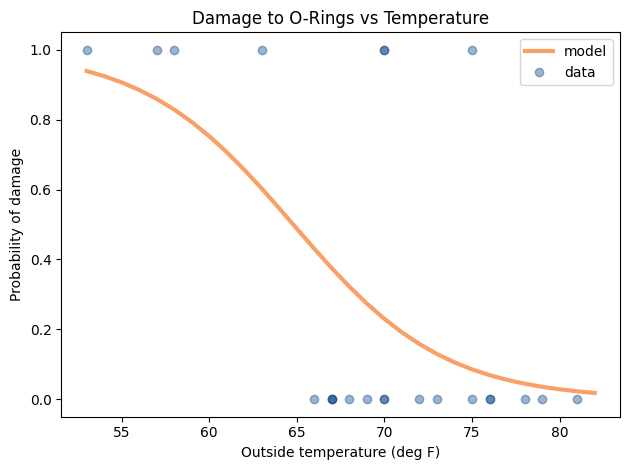

In [26]:
plt.plot(xs+offset, ps, label='model', color='C1')

plot_data(data)

At low temperatures, the probability of damage is high; at high temperatures, it drops off to near 0.

But that's based on conventional logistic regression.
Now we'll do the Bayesian version.

## Prior Distribution

I'll use uniform distributions for both parameters, using the point estimates from the previous section to help me choose the upper and lower bounds.

In [27]:
from utils import make_uniform

qs = np.linspace(-5, 1, num=101)
prior_inter = make_uniform(qs, 'Intercept')

In [28]:
qs = np.linspace(-0.8, 0.1, num=101)
prior_slope = make_uniform(qs, 'Slope')

We can use `make_joint` to construct the joint prior distribution.

In [29]:
from utils import make_joint

joint = make_joint(prior_inter, prior_slope)

The values of `intercept` run across the columns, the values of `slope` run down the rows.

For this problem, it will be convenient to "stack" the prior so the parameters are levels in a `MultiIndex`, and put the result in a `Pmf`.

In [30]:
from empiricaldist import Pmf

joint_pmf = Pmf(joint.stack())
joint_pmf.head()

Slope  Intercept
-0.8   -5.00        0.000098
       -4.94        0.000098
       -4.88        0.000098
dtype: float64

`joint_pmf` is a `Pmf` with two levels in the index, one for each parameter.  That makes it easy to loop through possible pairs of parameters, as we'll see in the next section.

## Likelihood

To do the update, we have to compute the likelihood of the data for each possible pair of parameters.  

To make that easier, I'm going to group the data by temperature, `x`, and count the number of launches and damage incidents at each temperature.

In [31]:
grouped = data.groupby('x')['y'].agg(['count', 'sum'])
grouped.head()

,count,sum
x,,
-17.0,1,1
-13.0,1,1
-12.0,1,1
-7.0,1,1
-4.0,1,0


The result is a `DataFrame` with two columns: `count` is the number of launches at each temperature; `sum` is the number of damage incidents.
To be consistent with the parameters of the binomial distributions, I'll assign them to variables named `ns` and `ks`.

In [32]:
ns = grouped['count']
ks = grouped['sum']

To compute the likelihood of the data, let's assume temporarily that the parameters we just estimated, `slope` and `inter`,  are correct.

We can use them to compute the probability of damage at each launch temperature, like this:

In [33]:
xs = grouped.index
ps = expit(inter + slope * xs)

`ps` contains the probability of damage for each launch temperature, according to the model.

Now, for each temperature we have `ns`, `ps`, and `ks`;
we can use the binomial distribution to compute the likelihood of the data.

In [34]:
from scipy.stats import binom

likes = binom.pmf(ks, ns, ps)
likes

array([0.93924781, 0.85931657, 0.82884484, 0.60268105, 0.56950687,
       0.24446388, 0.67790595, 0.72637895, 0.18815003, 0.8419509 ,
       0.87045398, 0.15645171, 0.86667894, 0.95545945, 0.96435859,
       0.97729671])

Each element of `likes` is the probability of seeing `k` damage incidents in `n` launches if the probability of damage is `p`.
The likelihood of the whole dataset is the product of this array.

In [35]:
likes.prod()

0.0004653644508250075

That's how we compute the likelihood of the data for a particular pair of parameters.
Now we can compute the likelihood of the data for all possible pairs:

In [38]:
likelihood = joint_pmf.copy()
for slope, inter in joint_pmf.index:
    ps = expit(inter + slope * xs)
    likes = binom.pmf(ks, ns, ps)
    likelihood[slope, inter] = likes.prod()

To initialize `likelihood`, we make a copy of `joint_pmf`, which is a convenient way to make sure that `likelihood` has the same type, index, and data type as `joint_pmf`.

The loop iterates through the parameters.  For each possible pair, it uses the logistic model to compute `ps`, computes the likelihood of the data, and assigns the result to a row in `likelihood`.

## The Update

Now we can compute the posterior distribution in the usual way.

In [39]:
posterior_pmf = joint_pmf * likelihood
posterior_pmf.normalize()

3.508992289655618e-05

Because we used a uniform prior, the parameter pair with the highest likelihood is also the pair with maximum posterior probability:

In [40]:
pd.Series(posterior_pmf.max_prob(),
          index=['slope', 'inter'])

slope   -0.233
inter   -1.220
dtype: float64

So we can confirm that the results of the Bayesian update are consistent with the maximum likelihood estimate computed by StatsModels:

In [41]:
results.params

Intercept   -1.208490
x           -0.232163
dtype: float64

They are approximately the same, within the precision of the grid we're using.

If we unstack the posterior `Pmf` we can make a contour plot of the joint posterior distribution.

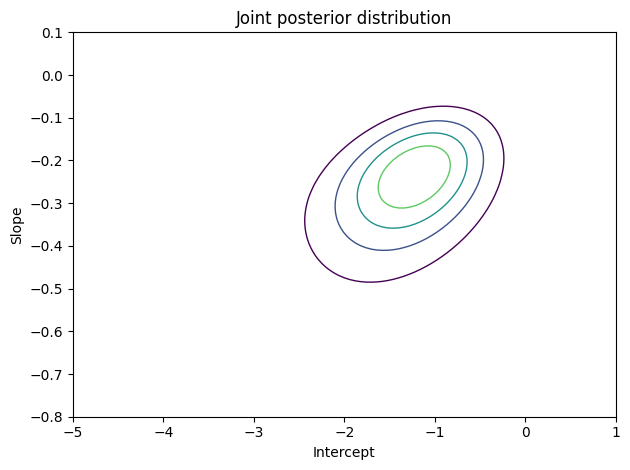

In [42]:
from utils import plot_contour

joint_posterior = posterior_pmf.unstack()
plot_contour(joint_posterior)
decorate(title='Joint posterior distribution')

The ovals in the contour plot are aligned along a diagonal, which indicates that there is some correlation between `slope` and `inter` in the posterior distribution.

But the correlation is weak, which is one of the reasons we subtracted off the mean launch temperature when we computed `x`; centering the data minimizes the correlation between the parameters.

**Exercise:** To see why this matters, go back and set `offset=60` and run the analysis again.
The slope should be the same, but the intercept will be different.  And if you plot the joint distribution, the contours you get will be elongated, indicating stronger correlation between the estimated parameters.  

In theory, this correlation is not a problem, but in practice it is.  With uncentered data, the posterior distribution is more spread out, so it's harder to cover with the joint prior distribution.
Centering the data maximizes the precision of the estimates; with uncentered data, we have to do more computation to get the same precision.

## Marginal Distributions

Finally, we can extract the marginal distributions.

In [43]:
from utils import marginal

marginal_inter = marginal(joint_posterior, 0)
marginal_slope = marginal(joint_posterior, 1)

Here's the posterior distribution of `inter`.

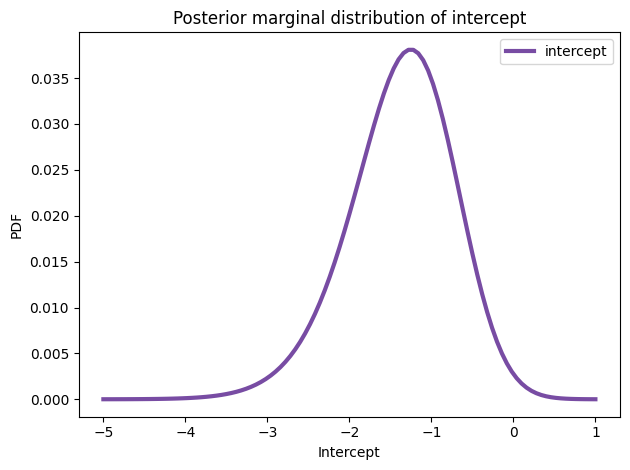

In [44]:

marginal_inter.plot(label='intercept', color='C4')

decorate(xlabel='Intercept',
         ylabel='PDF',
         title='Posterior marginal distribution of intercept')

And here's the posterior distribution of `slope`.

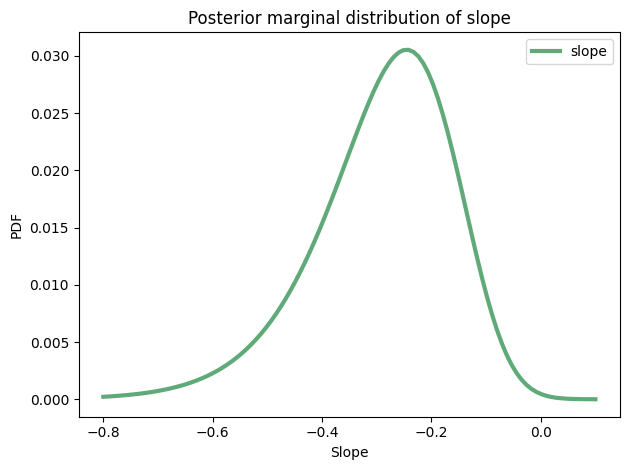

In [45]:
marginal_slope.plot(label='slope', color='C2')

decorate(xlabel='Slope',
         ylabel='PDF',
         title='Posterior marginal distribution of slope')

Here are the posterior means.

In [46]:
pd.Series([marginal_inter.mean(), marginal_slope.mean()],
          index=['inter', 'slope'])

inter   -1.376107
slope   -0.289795
dtype: float64

Both marginal distributions are moderately skewed, so the posterior means are somewhat different from the point estimates.

In [47]:
results.params

Intercept   -1.208490
x           -0.232163
dtype: float64

## Transforming Distributions

Let's interpret these parameters.  Recall that the intercept is the log odds of the hypothesis when $x$ is 0, which is when temperature is about 70 degrees F (the value of `offset`).
So we can interpret the quantities in `marginal_inter` as log odds.

To convert them to probabilities, I'll use the following function, which transforms the quantities in a `Pmf` by applying a given function:

In [48]:
def transform(pmf, func):
    """Transform the quantities in a Pmf."""
    ps = pmf.ps
    qs = func(pmf.qs)
    return Pmf(ps, qs, copy=True)

If we call `transform` and pass `expit` as a parameter, it transforms the log odds in `marginal_inter` into probabilities and returns the posterior distribution of `inter` expressed in terms of probabilities.

In [49]:
marginal_probs = transform(marginal_inter, expit)

`Pmf` provides a `transform` method that does the same thing.

In [50]:
marginal_probs = marginal_inter.transform(expit)

Here's the posterior distribution for the probability of damage at 70 degrees F.

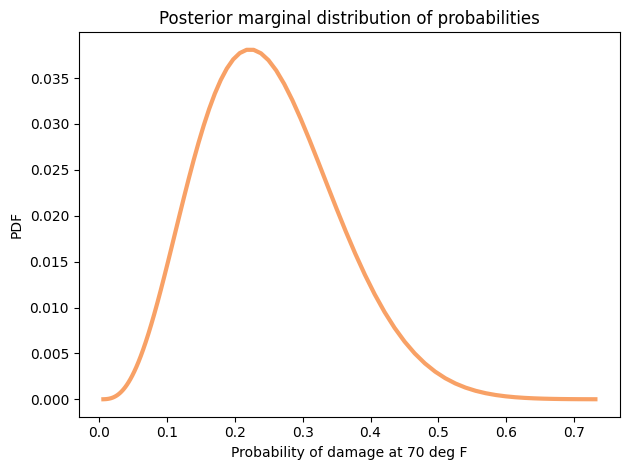

In [51]:
marginal_probs.plot(color='C1')

decorate(xlabel='Probability of damage at 70 deg F',
         ylabel='PDF',
         title='Posterior marginal distribution of probabilities')

The mean of this distribution is about 22%, which is the probability of damage at 70 degrees F, according to the model.

In [52]:
mean_prob = marginal_probs.mean()
mean_prob

0.2201937884647988

This result shows the second reason I defined `x` to be zero when temperature is 70 degrees F; this way, the intercept corresponds to the probability of damage at a relevant temperature, rather than 0 degrees F.

Now let's look more closely at the estimated slope.  In the logistic model, the parameter $\beta_1$ is the log of the likelihood ratio.  

So we can interpret the quantities in `marginal_slope` as log likelihood ratios, and we can use `exp` to transform them to likelihood ratios (also known as Bayes factors).

In [53]:
marginal_lr = marginal_slope.transform(np.exp)

The result is the posterior distribution of likelihood ratios; here's what it looks like.

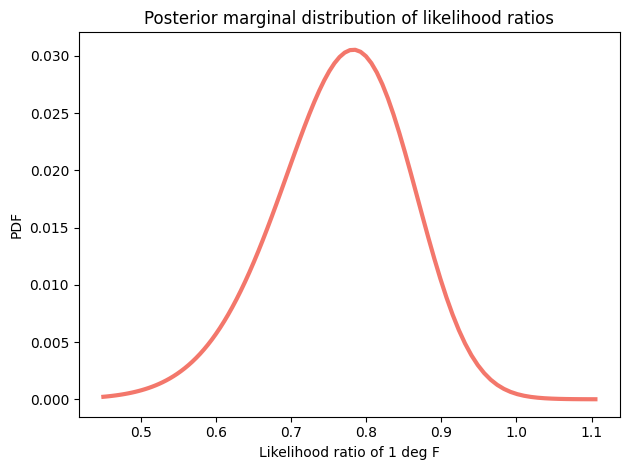

In [54]:
marginal_lr.plot(color='C3')

decorate(xlabel='Likelihood ratio of 1 deg F',
         ylabel='PDF',
         title='Posterior marginal distribution of likelihood ratios')

In [55]:
mean_lr = marginal_lr.mean()
mean_lr

0.7542914170110268

The mean of this distribution is about 0.75, which means that each additional degree Fahrenheit provides evidence against the possibility of damage, with a likelihood ratio (Bayes factor) of 0.75.

Notice:

* I computed the posterior mean of the probability of damage at 70 deg F by transforming the marginal distribution of the intercept to the marginal distribution of probability, and then computing the mean.

* I computed the posterior mean of the likelihood ratio by transforming the marginal distribution of slope to the marginal distribution of likelihood ratios, and then computing the mean.

This is the correct order of operations, as opposed to computing the posterior means first and then transforming them.  

To see the difference, let's compute both values the other way around.
Here's the posterior mean of `marginal_inter`, transformed to a probability, compared to the mean of `marginal_probs`.

In [56]:
expit(marginal_inter.mean()), marginal_probs.mean()

(0.2016349762400815, 0.2201937884647988)

And here's the posterior mean of `marginal_slope`, transformed to a likelihood ratio, compared to the mean `marginal_lr`.

In [57]:
np.exp(marginal_slope.mean()), marginal_lr.mean()

(0.7484167954660071, 0.7542914170110268)

In this example, the differences are not huge, but they can be.
As a general rule, transform first, then compute summary statistics.

## Predictive Distributions

In the logistic model, the parameters are interpretable, at least after transformation.  But often what we care about are predictions, not parameters.  In the Space Shuttle problem, the most important prediction is, "What is the probability of O-ring damage if the outside temperature is 31 degrees F?"

To make that prediction, I'll draw a sample of parameter pairs from the posterior distribution.

In [58]:
np.random.seed(17)

In [59]:
sample = posterior_pmf.choice(101)

The result is an array of 101 tuples, each representing a possible pair of parameters.
I chose this sample size to make the computation fast.
Increasing it would not change the results much, but they would be a little more precise.

In [60]:
sample.shape

(101,)

In [61]:
sample.dtype

dtype('O')

In [62]:
type(sample[0])

tuple

To generate predictions, I'll use a range of temperatures from 31 degrees F (the temperature when the Challenger launched) to 82 degrees F (the highest observed temperature).

In [63]:
temps = np.arange(31, 83)
xs = temps - offset

The following loop uses `xs` and the sample of parameters to construct an array of predicted probabilities.

In [64]:
pred = np.empty((len(sample), len(xs)))

for i, (slope, inter) in enumerate(sample):
    pred[i] = expit(inter + slope * xs)

The result has one column for each value in `xs` and one row for each element of `sample`.  

To get a quick sense of what the predictions look like, we can loop through the rows and plot them.

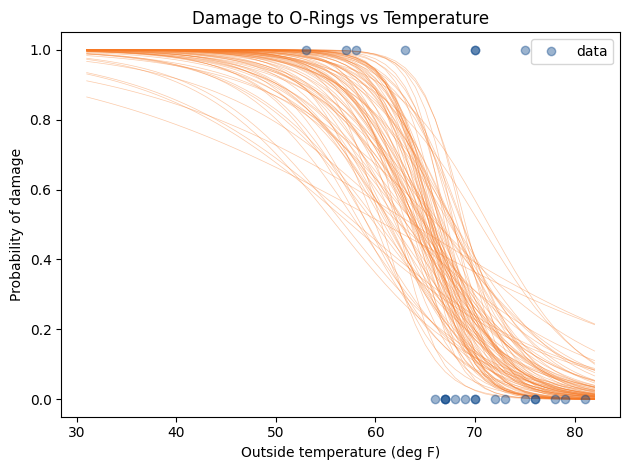

In [65]:
for ps in pred:
    plt.plot(temps, ps, color='C1', lw=0.5, alpha=0.4)

plot_data(data)

The overlapping lines in this figure give a sense of the most likely value at each temperature and the degree of uncertainty.

In each column, I'll compute the median to quantify the central tendency and a 90% credible interval to quantify the uncertainty.

`np.percentile` computes the given percentiles; with the argument `axis=0`, it computes them for each column.

In [66]:
low, median, high = np.percentile(pred, [5, 50, 95], axis=0)

The results are arrays containing predicted probabilities for the lower bound of the 90% CI, the median, and the upper bound of the CI.

Here's what they look like:

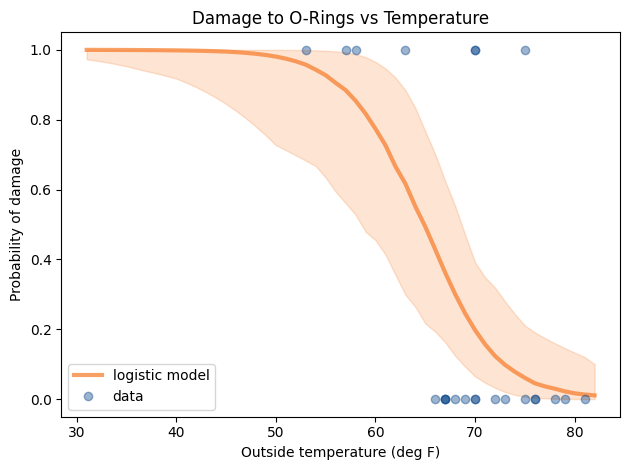

In [67]:
plt.fill_between(temps, low, high, color='C1', alpha=0.2)
plt.plot(temps, median, color='C1', label='logistic model')

plot_data(data)

According to these results, the probability of damage to the O-rings at 80 degrees F is near 2%, but there is some uncertainty about that prediction; the upper bound of the CI is around 10%.

At 60 degrees, the probability of damage is near 80%, but the CI is even wider, from 48% to 97%.

But the primary goal of the model is to predict the probability of damage at 31 degrees F, and the answer is at least 97%, and more likely to be more than 99.9%.

In [68]:
low = pd.Series(low, temps)
median = pd.Series(median, temps)
high = pd.Series(high, temps)

In [69]:
t = 80
print(median[t], (low[t], high[t]))

0.016956535510200765 (0.000563939208692237, 0.1335417225332125)


In [70]:
t = 60
print(median[t], (low[t], high[t]))

0.7738185742694538 (0.45512110762641983, 0.9654437697137236)


In [71]:
t = 31
print(median[t], (low[t], high[t]))

0.9998129598124814 (0.97280101769455, 0.999999987740933)


One conclusion we might draw is this:  If the people responsible for the Challenger launch had taken into account all of the data, and not just the seven damage incidents, they could have predicted that the probability of damage at 31 degrees F was nearly certain.  If they had, it seems likely they would have postponed the launch.

At the same time, if they considered the previous figure, they might have realized that the model makes predictions that extend far beyond the data.  When we extrapolate like that, we have to remember not just the uncertainty quantified by the model, which we expressed as a credible interval; we also have to consider the possibility that the model itself is unreliable.

This example is based on a logistic model, which assumes that each additional degree of temperature contributes the same amount of evidence in favor of (or against) the possibility of damage.  Within a narrow range of temperatures, that might be a reasonable assumption, especially if it is supported by data.  But over a wider range, and beyond the bounds of the data, reality has no obligation to stick to the model.

## Empirical Bayes

In this chapter I used StatsModels to compute the parameters that maximize the probability of the data, and then used those estimates to choose the bounds of the uniform prior distributions.
It might have occurred to you that this process uses the data twice, once to choose the priors and again to do the update.  If that bothers you, you are not alone.
The process I used is an example of what's called the [Empirical Bayes method](https://en.wikipedia.org/wiki/Empirical_Bayes_method), although I don't think that's a particularly good name for it.

Although it might seem problematic to use the data twice, in these examples, it is not.  To see why, consider an alternative: instead of using the estimated parameters to choose the bounds of the prior distribution, I could have used uniform distributions with much wider ranges.
In that case, the results would be the same; the only difference is that I would spend more time computing likelihoods for parameters where the posterior probabilities are negligibly small.

So you can think of this version of Empirical Bayes as an optimization that minimizes computation by putting the prior distributions where the likelihood of the data is worth computing.
This optimization doesn't affect the results, so it doesn't "double-count" the data.

## Summary

So far we have seen three ways to represent degrees of confidence in a hypothesis: probability, odds, and log odds.
When we write Bayes's Rule in terms of log odds, a Bayesian update is the sum of the prior and the likelihood; in this sense, Bayesian statistics is the arithmetic of hypotheses and evidence.

This form of Bayes's Theorem is also the foundation of logistic regression, which we used to infer parameters and make predictions.  In the Space Shuttle problem, we modeled the relationship between temperature and the probability of damage, and showed that the Challenger disaster might have been predictable.  But this example is also a warning about the hazards of using a model to extrapolate far beyond the data.

In the exercises below you'll have a chance to practice the material in this chapter, using log odds to evaluate a political pundit and using logistic regression to model diagnosis rates for Attention Deficit Hyperactivity Disorder (ADHD).

In the next chapter we'll move from logistic regression to linear regression, which we will use to model changes over time in temperature, snowfall, and the marathon world record.

## Exercises

**Exercise:** Suppose a political pundit claims to be able to predict the outcome of elections, but instead of picking a winner, they give each candidate a probability of winning.
With that kind of prediction, it can be hard to say whether it is right or wrong.

For example, suppose the pundit says that Alice has a 70% chance of beating Bob, and then Bob wins the election.  Does that mean the pundit was wrong?

One way to answer this question is to consider two hypotheses:

* `H`: The pundit's algorithm is legitimate; the probabilities it produces are correct in the sense that they accurately reflect the candidates' probabilities of winning.

* `not H`: The pundit's algorithm is bogus; the probabilities it produces are random values with a mean of 50%.

If the pundit says Alice has a 70% chance of winning, and she does, that provides evidence in favor of `H` with likelihood ratio 70/50.

If the pundit says Alice has a 70% chance of winning, and she loses, that's evidence against `H` with a likelihood ratio of 50/30.

Suppose we start with some confidence in the algorithm, so the prior odds are 4 to 1.  And suppose the pundit generates predictions for three elections:

* In the first election, the pundit says Alice has a 70% chance of winning and she does.

* In the second election, the pundit says Bob has a 30% chance of winning and he does.

* In the third election, the pundit says Carol has an 90% chance of winning and she does.

What is the log likelihood ratio for each of these outcomes?  Use the log-odds form of Bayes's Rule to compute the posterior log odds for `H` after these outcomes.  In total, do these outcomes increase or decrease your confidence in the pundit?

If you are interested in this topic, you can [read more about it in this blog post](http://allendowney.blogspot.com/2016/11/why-are-we-so-surprised.html).

In [72]:
prior_log_odds = np.log(4)
prior_log_odds

1.3862943611198906

In [73]:
lr1 = np.log(7/5)
lr2 = np.log(3/5)
lr3 = np.log(9/5)

lr1, lr2, lr3

(0.3364722366212129, -0.5108256237659907, 0.5877866649021191)

In [74]:
# In total, these three outcomes provide evidence that the
# pundit's algorithm is legitmate, although with K=1.8,
# it is weak evidence.

posterior_log_odds = prior_log_odds + lr1 + lr2 + lr3
posterior_log_odds

1.7997276388772319

**Exercise:**  An article in the *New England Journal of Medicine* reports results from a study that looked at the diagnosis rate of Attention Deficit Hyperactivity Disorder (ADHD) as a function of birth month: ["Attention Deficit–Hyperactivity Disorder and Month of School Enrollment"](https://www.nejm.org/doi/10.1056/NEJMoa1806828).

They found that children born in June, July, and August were substantially more likely to be diagnosed with ADHD, compared to children born in September, but only in states that use a September cutoff for children to enter kindergarten.  In these states, children born in August start school almost a year younger than children born in September.  The authors of the study suggest that the cause is "age-based variation in behavior that may be attributed to ADHD rather than to the younger age of the children".

Use the methods in this chapter to estimate the probability of diagnosis as a function of birth month.
The notebook for this chapter provides the data and some suggestions for getting started.

The paper includes this figure:

<img width="500" src="https://www.nejm.org/na101/home/literatum/publisher/mms/journals/content/nejm/2018/nejm_2018.379.issue-22/nejmoa1806828/20190131/images/img_xlarge/nejmoa1806828_f1.jpeg">

In my opinion, this representation of the data does not show the effect as clearly as it could.

But the figure includes the raw data, so we can analyze it ourselves.

Note: there is an error in the figure, confirmed by personal correspondence:

> The May and June [diagnoses] are reversed. May should be 317 (not 287) and June should be 287 (not 317).

So here is the corrected data, where `n` is the number of children born in each month, starting with January, and `k` is the number of children diagnosed with ADHD.

In [75]:
n = np.array([32690, 31238, 34405, 34565, 34977, 34415,
                   36577, 36319, 35353, 34405, 31285, 31617])

k = np.array([265, 280, 307, 312, 317, 287,
                      320, 309, 225, 240, 232, 243])

First, I'm going to "roll" the data so it starts in September rather than January.

In [76]:
x = np.arange(12)
n = np.roll(n, -8)
k = np.roll(k, -8)

And I'll put it in a `DataFrame` with one row for each month and the diagnosis rate per 10,000.

In [77]:
adhd = pd.DataFrame(dict(x=x, k=k, n=n))
adhd['rate'] = adhd['k'] / adhd['n'] * 10000
adhd

,x,k,n,rate
0,0,225,35353,63.643821
1,1,240,34405,69.757303
2,2,232,31285,74.156944
3,3,243,31617,76.857387
4,4,265,32690,81.064546
5,5,280,31238,89.634420
6,6,307,34405,89.231216
7,7,312,34565,90.264719
8,8,317,34977,90.630986
9,9,287,34415,83.393869


Here's what the diagnosis rates look like.

In [78]:
def plot_adhd(adhd):
    plt.plot(adhd['x'], adhd['rate'], 'o',
             label='data', color='C0', alpha=0.4)

    plt.axvline(5.5, color='gray', alpha=0.2)
    plt.text(6, 64, 'Younger than average')
    plt.text(5, 64, 'Older than average', horizontalalignment='right')

    decorate(xlabel='Birth date, months after cutoff',
             ylabel='Diagnosis rate per 10,000')

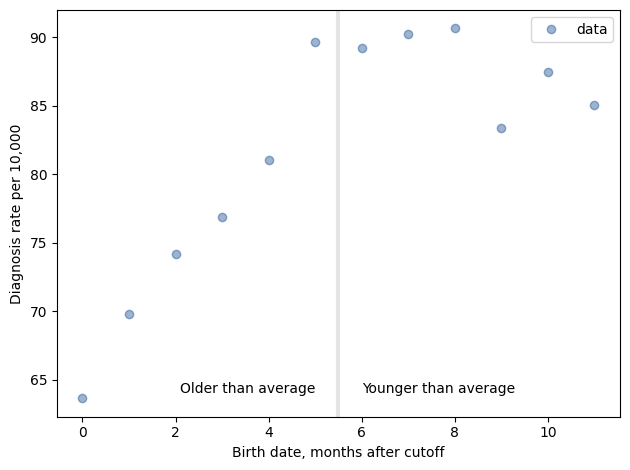

In [79]:
plot_adhd(adhd)

For the first 9 months, from September to May, we see what we would expect if some of the excess diagnoses are due to "age-based variation in behavior".  For each month of difference in age, we see an increase in the number of diagnoses.

This pattern breaks down for the last three months, June, July, and August.  This might be explained by random variation, but it also might be due to parental manipulation; if some parents hold back children born near the deadline, the observations for these month would include a mixture of children who are relatively old for their grade and therefore less likely to be diagnosed.

Unfortunately, the dataset includes only month of birth, not year, so we don't know the actual ages of these students when they started school.  However, we can use the first nine months to estimate the effect of age on diagnosis rate; then we can think about what to do with the other three months.

Use the methods in this chapter to estimate the probability of diagnosis as a function of birth month.
Start with the following prior distributions.

In [80]:
qs = np.linspace(-5.2, -4.6, num=51)
prior_inter = make_uniform(qs, 'Intercept')

In [81]:
qs = np.linspace(0.0, 0.08, num=51)
prior_slope = make_uniform(qs, 'Slope')

1. Make a joint prior distribution and update it using the data for the first nine months.

2. Then draw a sample from the posterior distribution and use it to compute the median probability of diagnosis for each month and a 90% credible interval.

3. As a bonus exercise, do a second update using the data from the last three months, but treating the observed number of diagnoses as a lower bound on the number of diagnoses there would be if no children were kept back.

In [82]:
joint = make_joint(prior_inter, prior_slope)
joint.head()

Intercept,-5.200,-5.188,-5.176,-5.164,-5.152,-5.140,-5.128,-5.116,-5.104,-5.092,...,-4.708,-4.696,-4.684,-4.672,-4.660,-4.648,-4.636,-4.624,-4.612,-4.600
Slope,,,,,,,,,,,,,,,,,,,,,
0.0000,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,...,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384
0.0016,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,...,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384
0.0032,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,...,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384
0.0048,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,...,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384
0.0064,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,...,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384


In [83]:
joint_pmf = Pmf(joint.stack())
joint_pmf.head()

Slope  Intercept
0.0    -5.200       0.000384
       -5.188       0.000384
       -5.176       0.000384
dtype: float64

In [84]:
num_legit = 9
adhd1 = adhd.loc[0:num_legit-1]
adhd2 = adhd.loc[num_legit:]
adhd1

,x,k,n,rate
0,0,225,35353,63.643821
1,1,240,34405,69.757303
2,2,232,31285,74.156944
3,3,243,31617,76.857387
4,4,265,32690,81.064546
5,5,280,31238,89.634420
6,6,307,34405,89.231216
7,7,312,34565,90.264719
8,8,317,34977,90.630986


In [85]:
adhd2

,x,k,n,rate
9,9,287,34415,83.393869
10,10,320,36577,87.486672
11,11,309,36319,85.079435


In [86]:
from scipy.stats import binom

likelihood1 = joint_pmf.copy()

xs = adhd1['x']
ks = adhd1['k']
ns = adhd1['n']

for slope, inter in joint_pmf.index:
    ps = expit(inter + slope * xs)
    likes = binom.pmf(ks, ns, ps)
    likelihood1[slope, inter] = likes.prod()

likelihood1.sum()

3.543685818699967e-14

In [87]:
# This update uses the binomial survival function to compute
# the probability that the number of cases *exceeds* `ks`.

likelihood2 = joint_pmf.copy()

xs = adhd2['x']
ks = adhd2['k']
ns = adhd2['n']

for slope, inter in joint_pmf.index:
    ps = expit(inter + slope * xs)
    likes = binom.sf(ks, ns, ps)
    likelihood2[slope, inter] = likes.prod()

likelihood2.sum()

1905.3511925074408

In [88]:
posterior_pmf = joint_pmf * likelihood1
posterior_pmf.normalize()

1.3624320717800717e-17

In [89]:
posterior_pmf.max_prob()

(0.0448, -4.996)

In [90]:
posterior_pmf = joint_pmf * likelihood1 * likelihood1
posterior_pmf.normalize()

4.625645571869131e-33

In [91]:
posterior_pmf.max_prob()

(0.0448, -4.996)

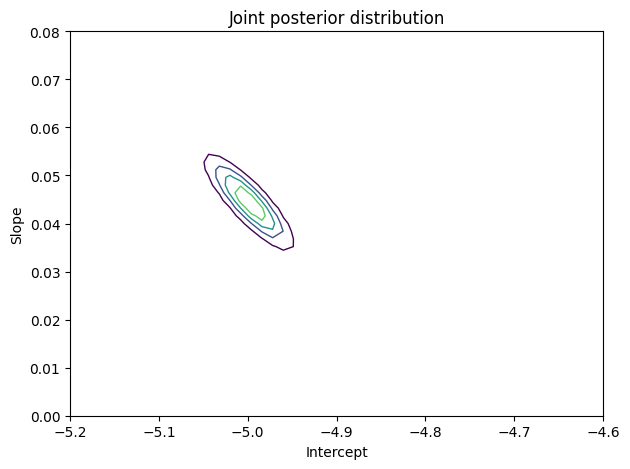

In [92]:
joint_posterior = posterior_pmf.unstack()

plot_contour(joint_posterior)
decorate(title='Joint posterior distribution')

In [93]:
marginal_inter = marginal(joint_posterior, 0)
marginal_slope = marginal(joint_posterior, 1)

marginal_inter.mean(), marginal_slope.mean()

(-4.998484813267186, 0.04439980053203755)

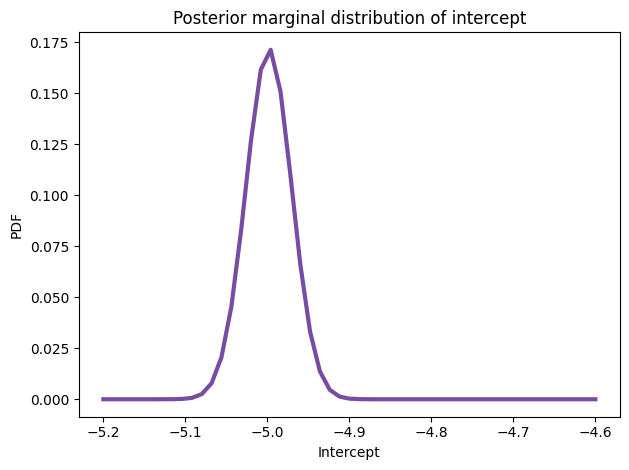

In [94]:
marginal_inter.plot(color='C4')
decorate(xlabel='Intercept',
         ylabel='PDF',
         title='Posterior marginal distribution of intercept')

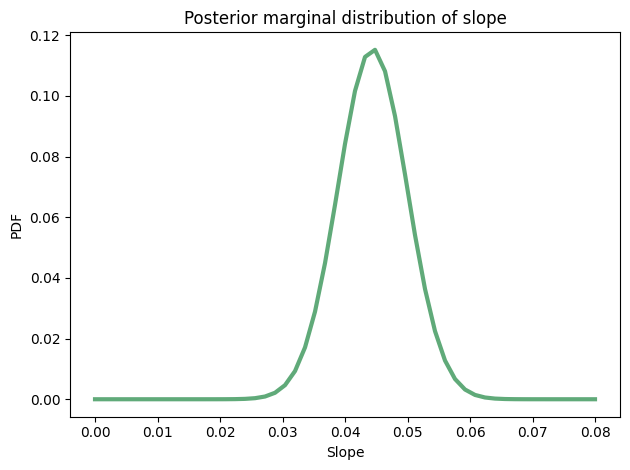

In [95]:
marginal_slope.plot(color='C2')

decorate(xlabel='Slope',
         ylabel='PDF',
         title='Posterior marginal distribution of slope')

In [96]:
sample = posterior_pmf.choice(101)
xs = adhd['x']
ps = np.empty((len(sample), len(xs)))

for i, (slope, inter) in enumerate(sample):
    ps[i] = expit(inter + slope * xs)

ps.shape

(101, 12)

In [97]:
low, median, high = np.percentile(ps, [2.5, 50, 97.5], axis=0)
median

array([0.0067195 , 0.00699181, 0.00732144, 0.00764219, 0.00798954,
       0.00835919, 0.00873192, 0.00909224, 0.00948231, 0.00992818,
       0.01035374, 0.010823  ])

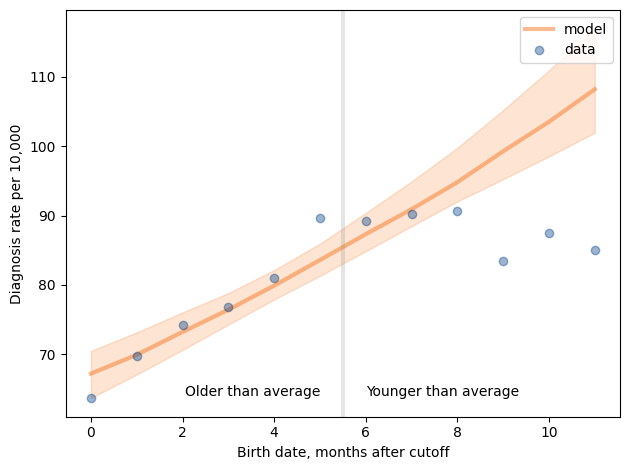

In [98]:
plt.fill_between(xs, low*10000, high*10000,
                 color='C1', alpha=0.2)

plt.plot(xs, median*10000, label='model',
         color='C1', alpha=0.5)

plot_adhd(adhd)